In [1]:
import pandas as pd
import sys
import os
if not sys.modules.get('pyarrow'):
    os.system('pip3 install pyarrow')
import numpy as np
from glob import glob
import datetime 
from dateutil.relativedelta import relativedelta
from collections import Counter
import numpy as np
from sklearn import metrics
import numpy as np
import operator

In [2]:
def month_vouch(m):
    if len(str(m))==1:
        return '0'+str(m)
    else:
        return str(m)

In [3]:
def pearson_cor(a,b):   
    if a.shape != b.shape:
        print('크기가 다른 데이터입니다.')            
    else:
        return((np.dot(a,b) - np.mean(a)*np.mean(b)*a.shape[0])/(a.shape[0]-1))/(np.std(a)*np.std(b))

In [4]:
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# 한글처리
plt.rcParams['axes.unicode_minus'] = False
if platform.system() == 'Darwin':    # 맥
    rc( 'font', family='AppleGothic' )
elif platform.system() == 'Windows': # 윈도우
    # 폰트 차후 확인
    fontPath = 'c:/Windows/Fonts/malgun.ttf'
    fontName = font_manager.FontProperties( fname=fontPath ).get_name()
    rc( 'font', family=fontName )
else:
    print('알수없는 시스템. 미적용')

In [5]:
from sklearn.linear_model import LogisticRegression
if not sys.modules.get('xgboost'):
    os.system('pip3 install xgboost')
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split

In [6]:
stock_code = '015760'
path = './data/freq2/naver_{0}_freq.parquet/'.format(stock_code)
file_name = os.listdir(path)[0]
data = pd.read_parquet(path+file_name)
#data['date'] = pd.to_datetime(data['date'], format='%Y.%m.%d', errors='ignore')
tag_dict= Counter()
all_dict = Counter()

In [7]:
data_sorting = data.sort_values(by='date')
data_sorting.reset_index(inplace=True,drop=True)

# 고려해야할 것
- 각 컬럼의 총 빈도를 계산하여 특정 빈도 이하는 제거
- 날짜 짝짓기
- 전날과 당일 빈도 묶기 - 주말,휴일 고려 

In [8]:
#특정 이하 빈도 제거 
sum_by_columns = data_sorting.drop(columns=['date']).sum(axis=0)
abs_path = os.path.abspath('../file_list/crawl_data/naver_{0}.csv'.format(stock_code))
csv_file = pd.read_csv(abs_path,header=None)
#print(csv_file.head(10))
filter_size = csv_file.shape[0]*0.03
filtered_index_series = sum_by_columns>filter_size
filtered_index = filtered_index_series[filtered_index_series==True].keys()
#date_list = ['date']
#data['date'].concat(sum_by_columns>filter_size)

#data_filter_freq = data_sorting.loc[:date_list.extend(filtered_index)]
data_filter_freq = data_sorting.loc[:,filtered_index]
# 수익률과 날짜를 맞춰주기 위해서 하루를 미뤄준다.

#day를 더해줬던 이유가 무엇일까?
data_filter_freq.index = data_sorting['date'].apply(lambda x:datetime.datetime(int(x.split('.')[0]),int(x.split('.')[1]),int(x.split('.')[2]))+relativedelta(days=1))
data_filter_freq = data_filter_freq.loc[:datetime.datetime(2018,11,30)]

In [9]:
data_filter_freq.head()

,!!/sf,!/sf,%/sw,.../se,../se,./se,./sf,1/sn,10/sn,2/sn,...,탈/xpn,투자/nng,팔/vv,하/vv,하락/nng,한/mm,한국/nnp,한국전력/nnp,한전/nnp,회사/nng
date,,,,,,,,,,,,,,,,,,,,,
2017-06-08,1,2,14,7,8,6,39,3,3,5,...,0,1,3,12,0,2,0,2,7,0
2017-06-09,1,5,2,4,6,3,28,4,1,1,...,0,0,4,27,1,4,1,1,8,1
2017-06-10,1,4,0,6,10,7,62,7,3,2,...,0,4,2,11,1,2,0,1,5,1
2017-06-11,0,4,0,2,2,2,52,3,1,3,...,1,1,0,19,0,4,0,0,1,3
2017-06-12,3,6,5,3,14,5,84,5,2,6,...,0,0,2,12,0,1,0,3,12,2


In [10]:
data_filter_freq.tail()

,!!/sf,!/sf,%/sw,.../se,../se,./se,./sf,1/sn,10/sn,2/sn,...,탈/xpn,투자/nng,팔/vv,하/vv,하락/nng,한/mm,한국/nnp,한국전력/nnp,한전/nnp,회사/nng
date,,,,,,,,,,,,,,,,,,,,,
2018-11-26,0,1,20,3,2,2,92,11,0,5,...,27,0,0,25,1,5,0,1,0,0
2018-11-27,15,26,19,7,12,8,163,18,5,21,...,35,1,8,39,9,5,5,6,14,2
2018-11-28,2,11,3,5,12,7,84,4,4,2,...,15,1,10,23,1,2,2,2,14,1
2018-11-29,22,40,22,13,8,15,238,37,11,22,...,28,9,15,41,8,10,18,12,35,4
2018-11-30,2,5,12,5,2,6,209,20,10,10,...,24,2,2,58,3,4,28,4,19,3


In [11]:
#### 보류
#날짜 짝짓기
#첫행 처리는 어떻게 할것인가? 없으면 더해주지 않는다. 있으면 더한다. 

In [12]:
# 7월 30일 데이터는 없다.
#data_filter_freq.loc[datetime.datetime(year=2017,month=7,day=30),:]

In [13]:
# ### 수익률 데이터 처리
# earning_month_raw = pd.read_csv('./data/일일수익률_시가.csv')
# # 해당 열 추출
# # symbol = earning_month_raw.loc[:,'A'+stock_code]
# # return_data =symbol
# earning_data = earning_data_raw[datetime.datetime(year=2017,month=6,day=8):datetime.datetime(year=2018,month=11,day=30)]


In [14]:
### 수익률 데이터 처리
earning_month_raw = pd.read_excel('./data/한국전력(수익률).xlsx',index=True)
tmp_data = earning_month_raw.iloc[5:,:]



tmp_data.index = tmp_data.loc[:,'Symbol']

return_data = tmp_data['A'+stock_code]




earning_data = return_data[datetime.datetime(year=2017,month=6,day=8):datetime.datetime(year=2018,month=11,day=30)]

In [15]:
# ### 수익률 데이터 처리
# earning_month_raw = pd.read_excel('./data/일일수익률.xlsx')

# symbol = earning_month_raw.loc['Symbol Name':,:]
# symbol.columns = earning_month_raw.loc['Symbol']

# # 해당 열 추출
# return_data = symbol['A'+stock_code]


# earning_data = return_data[datetime.datetime(year=2017,month=6,day=8):datetime.datetime(year=2018,month=11,day=30)]


In [16]:
earning_data

Symbol
2017-06-08     700
2017-06-09       0
2017-06-10     -50
2017-06-11     -50
2017-06-12    -150
2017-06-13       0
2017-06-14    -250
2017-06-15    -100
2017-06-16     100
2017-06-17    -100
2017-06-18    -100
2017-06-19    -250
2017-06-20    -250
2017-06-21     250
2017-06-22     250
2017-06-23     100
2017-06-24    -150
2017-06-25    -150
2017-06-26       0
2017-06-27    -650
2017-06-28    -700
2017-06-29     100
2017-06-30    -250
2017-07-01    -200
2017-07-02    -200
2017-07-03    -100
2017-07-04     100
2017-07-05    -100
2017-07-06       0
2017-07-07       0
              ... 
2018-11-01      50
2018-11-02    -150
2018-11-03     150
2018-11-04     150
2018-11-05     -50
2018-11-06    -100
2018-11-07     -50
2018-11-08     100
2018-11-09       0
2018-11-10    -700
2018-11-11    -700
2018-11-12      50
2018-11-13       0
2018-11-14     700
2018-11-15     100
2018-11-16     100
2018-11-17       0
2018-11-18       0
2018-11-19      50
2018-11-20     100
2018-11-21     250
2018-

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


In [18]:
earning_data

Symbol
2017-06-08     700
2017-06-09       0
2017-06-10     -50
2017-06-11     -50
2017-06-12    -150
2017-06-13       0
2017-06-14    -250
2017-06-15    -100
2017-06-16     100
2017-06-17    -100
2017-06-18    -100
2017-06-19    -250
2017-06-20    -250
2017-06-21     250
2017-06-22     250
2017-06-23     100
2017-06-24    -150
2017-06-25    -150
2017-06-26       0
2017-06-27    -650
2017-06-28    -700
2017-06-29     100
2017-06-30    -250
2017-07-01    -200
2017-07-02    -200
2017-07-03    -100
2017-07-04     100
2017-07-05    -100
2017-07-06       0
2017-07-07       0
              ... 
2018-11-01      50
2018-11-02    -150
2018-11-03     150
2018-11-04     150
2018-11-05     -50
2018-11-06    -100
2018-11-07     -50
2018-11-08     100
2018-11-09       0
2018-11-10    -700
2018-11-11    -700
2018-11-12      50
2018-11-13       0
2018-11-14     700
2018-11-15     100
2018-11-16     100
2018-11-17       0
2018-11-18       0
2018-11-19      50
2018-11-20     100
2018-11-21     250
2018-

335.41728934678247


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


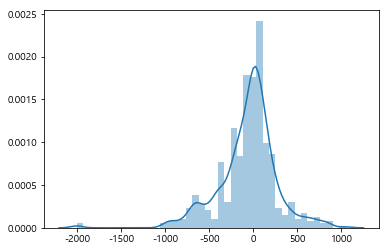

In [19]:
sns.distplot(list(earning_data))
print(earning_data.std())

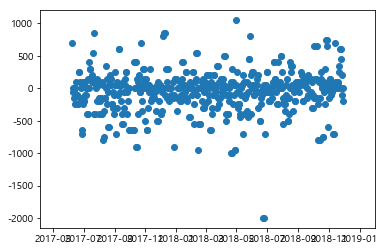

In [20]:
plt.scatter(earning_data.index,earning_data) #일일 변화율은 안정적인 편이다.

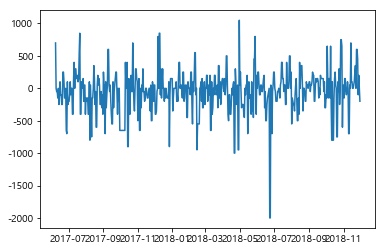

In [21]:
plt.plot(earning_data)

In [22]:
# earning_data의 전날 텍스트 빈도와 earning_data의 수익률의 짝을 맞춰야한다. 
# 주말과 휴일을 고려해야한다.
# 합치기 위해서는 earning_data의 index 정보가 필요하다.

#earning_data.index =  [date- relativedelta(days=1) for date in earning_data.index]

In [23]:
earning_data.tail()

Symbol
2018-11-26     450
2018-11-27    -100
2018-11-28     200
2018-11-29       0
2018-11-30    -200
Name: A015760, dtype: object

In [24]:
# 이 날짜에 있는 빈도를 수익률과 상관계수를 구할거임
data_filter_freq.index 

DatetimeIndex(['2017-06-08', '2017-06-09', '2017-06-10', '2017-06-11',
               '2017-06-12', '2017-06-13', '2017-06-14', '2017-06-15',
               '2017-06-16', '2017-06-17',
               ...
               '2018-11-21', '2018-11-22', '2018-11-23', '2018-11-24',
               '2018-11-25', '2018-11-26', '2018-11-27', '2018-11-28',
               '2018-11-29', '2018-11-30'],
              dtype='datetime64[ns]', name='date', length=541, freq=None)

In [25]:
data_filter_freq.loc[datetime.datetime(year=2017,month=12,day=25):,:]

,!!/sf,!/sf,%/sw,.../se,../se,./se,./sf,1/sn,10/sn,2/sn,...,탈/xpn,투자/nng,팔/vv,하/vv,하락/nng,한/mm,한국/nnp,한국전력/nnp,한전/nnp,회사/nng
date,,,,,,,,,,,,,,,,,,,,,
2017-12-25,0,0,0,0,1,0,8,4,0,0,...,1,2,0,2,0,1,1,0,4,0
2017-12-26,0,13,8,1,2,1,111,6,2,4,...,3,0,0,18,0,1,4,1,2,0
2017-12-27,5,10,9,4,7,5,65,7,5,10,...,5,8,3,13,8,1,0,6,13,1
2017-12-28,2,4,5,5,12,7,41,7,0,8,...,0,0,7,3,3,4,0,2,7,1
2017-12-29,0,3,4,7,12,3,27,3,3,5,...,2,1,4,13,2,1,3,0,7,1
2017-12-30,1,1,2,3,1,0,17,1,3,5,...,2,1,0,11,2,5,1,4,7,0
2017-12-31,0,2,0,1,5,2,18,1,0,1,...,3,1,0,8,1,0,0,1,7,2
2018-01-01,14,15,3,0,1,0,70,3,3,1,...,3,1,0,16,1,3,5,3,4,0
2018-01-02,0,0,3,0,0,0,63,4,1,1,...,5,1,0,13,0,0,1,6,9,0


In [26]:
# print(differ_date[:10])

In [27]:
# a = differ_date[0:2]
# a.append('babo')

In [28]:
# differ_date

In [29]:
differ_date = sorted(list(set(data_filter_freq.index).difference(set(earning_data.index))))
#print(differ_date)
i = 0
for idx in range(len(differ_date)-1):
    #print(element)
    # 10 11 17 idx = 1
    if (differ_date[idx+1]-differ_date[idx]).days > 1:      
        #print(differ_date[i],differ_date[idx+1],data_filter_freq.loc[differ_date[i:idx+1],:].sum())
        # 휴일 or 주말이 끼면 그 날을 포함해서 다음 날에 반영한다.
        # 휴일 다음날 
        append_idx = differ_date[idx]+relativedelta(days=1)
        sum_list = differ_date[i:idx+1]
        sum_list.append(append_idx)
        data_filter_freq.loc[append_idx,:] = data_filter_freq.loc[sum_list,:].sum()//len(sum_list)
        data_filter_freq.drop(index = differ_date[i:idx+1],inplace=True)
        #del data_filter_freq.loc[differ_date[i:idx+1],:]
        #print(sum_list,'append_idx:',append_idx)
        i = idx+1

In [30]:
data_filter_freq.head(10) # 6월 7일 금 토 일 

,!!/sf,!/sf,%/sw,.../se,../se,./se,./sf,1/sn,10/sn,2/sn,...,탈/xpn,투자/nng,팔/vv,하/vv,하락/nng,한/mm,한국/nnp,한국전력/nnp,한전/nnp,회사/nng
date,,,,,,,,,,,,,,,,,,,,,
2017-06-08,1,2,14,7,8,6,39,3,3,5,...,0,1,3,12,0,2,0,2,7,0
2017-06-09,1,5,2,4,6,3,28,4,1,1,...,0,0,4,27,1,4,1,1,8,1
2017-06-10,1,4,0,6,10,7,62,7,3,2,...,0,4,2,11,1,2,0,1,5,1
2017-06-11,0,4,0,2,2,2,52,3,1,3,...,1,1,0,19,0,4,0,0,1,3
2017-06-12,3,6,5,3,14,5,84,5,2,6,...,0,0,2,12,0,1,0,3,12,2
2017-06-13,2,2,5,14,13,7,47,6,1,3,...,0,0,5,9,5,0,1,1,10,0
2017-06-14,1,3,1,5,8,1,56,2,3,3,...,0,1,2,5,1,2,0,2,4,3
2017-06-15,5,9,8,37,31,13,94,4,4,5,...,0,0,4,32,6,7,4,0,16,2
2017-06-16,1,20,1,10,12,6,178,36,20,31,...,0,1,4,31,5,3,0,2,8,0


In [31]:
print(len(data_filter_freq),len(earning_data))

541 541


In [32]:
differ_date1 = sorted(list(set(data_filter_freq.index).difference(set(earning_data.index))))

In [33]:
differ_date1 # 이유는 모르겠는데 이 때들 수익률이 없다. 그래서 지워보자

[]

In [34]:
data_filter_freq.drop(differ_date1,inplace=True,axis=0)

In [35]:
differ_date2 = sorted(list(set(earning_data.index).difference(set(data_filter_freq.index))))

In [36]:
differ_date2

[]

In [37]:
earning_data.drop(differ_date2, inplace=True, axis=0)

In [38]:
print(len(data_filter_freq),len(earning_data))

541 541


In [39]:
corr_dict = {}
for idx in range(data_filter_freq.shape[1]):
    tag = data_filter_freq.iloc[:,idx]
    if tag.name == './sf':
        continue
    corr = pearson_cor(np.array(tag),np.array(earning_data))
    #print(type(tag),type(corr))
    #tag_dict[tag.name] += 1
    corr_dict[tag.name] = corr

all_dict[stock_code] = sorted(corr_dict.items(), key=lambda x:abs(x[1]),reverse=True)

In [40]:
all_dict[stock_code]

[('20/sn', 0.09587106297833498),
 ('대하/vv', 0.08073336259847577),
 ('국가/nng', 0.07629334261448796),
 ('살/vv', 0.06697656692022755),
 ('좋/va', 0.06662981038468331),
 ('이익/nng', -0.06607412794317054),
 ('ㅋ/nng', 0.06550057930238105),
 ('투자/nng', 0.06204460674092099),
 ('중/nnb', 0.06072686747708909),
 ('그/mm', 0.060461768933513016),
 ('등/nnb', 0.05827879160654868),
 ('원/nnb', 0.058194148061399324),
 ('정책/nng', 0.0578920209571272),
 ('없/va', 0.05771791241156715),
 ('요금/nng', 0.056781781347809195),
 ('크/va', 0.056543334465705065),
 ('ㅋ/ic', 0.05565543897285402),
 ('년/nnb', 0.05262426472447576),
 ('일/nng', 0.0519755787867347),
 ('시장/nng', 0.051486402552355884),
 ('발전/nng', 0.05109958162589884),
 ('안/mag', 0.050155002579273335),
 ('8/sn', 0.04972186362946126),
 ('기/nng', 0.04920223169097462),
 ('전/nng', 0.048512196267526626),
 ('중국/nnp', 0.04824967213660546),
 ('나오/vv', -0.04742828859226834),
 ('ㅎ/nng', 0.04692681181145962),
 ('한/mm', 0.046425429440928666),
 ('만/jx', 0.04502121702852651),
 ('

In [41]:
# dictionary 초기화
def labeling(data):
    if data>0:
        data = 1
    elif data <0:
        data = -1
    return data

# RandomForest 0.33

In [42]:
%%time
model_result = Counter()
train_result= Counter()
test_result = Counter()
confusion_matrix_result = Counter()
auc_result = Counter()
one_code_list = all_dict[stock_code]
tag_list = [tag[0] for tag in one_code_list[:]]
y = np.array([labeling(label) for label in earning_data])
classifiers = []
random_state=[4000]
delete_index=[]
for idx, y_element in enumerate(y):    
    if y_element == 0:
        delete_index.append(idx)
x= data_filter_freq[tag_list]
y=np.delete(y,delete_index)
x.drop(index=x.index[delete_index],inplace=True)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=False)
lenx=X_train.shape

nfolds=5
criterion = ["gini", 'entropy']
#grid_search = GridSearchCV(SVC(), param_grid_svc, cv=nfolds)
n_estimators = [3,5,10,100,500,1000,2000]
scoring = 'accuracy'
rf_param_grid = {"max_depth": [3,5,10,15,20,50],
              "max_features": [5,10,30,50,100],
              "n_estimators" :n_estimators,
              "criterion": criterion,
                "random_state":random_state}
# rf_param_grid = {"max_depth": [3],
#               "max_features": [3],
#               "n_estimators" :[10],
#               "criterion": ['entropy'],
#                 'random_state':[4000]}


#gsExtC = GridSearchCV(ExtraTreesClassifier, param_grid = ex_param_grid, cv=nfold, scoring="auc")

print('X_train_shape:',X_train.shape)

classifiers.append(GridSearchCV(RandomForestClassifier(),param_grid = rf_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1))


for single_models in classifiers:    
    single_models.fit(X_train,y_train)
    
    model_str = str(single_models).split('(')[0]
    print(model_str,':',single_models.best_params_)
    pre = single_models.predict(X_test)
    
    
    print(single_models.score(X_test,y_test))
    print(single_models.score(X_train,y_train))    
    print(metrics.accuracy_score(y_test, pre))    

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


X_train_shape: (316, 139)
GridSearchCV : {'criterion': 'entropy', 'max_depth': 50, 'max_features': 5, 'n_estimators': 3, 'random_state': 4000}
0.5128205128205128
0.8955696202531646
0.5128205128205128
Wall time: 11min 9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [43]:
decision_model = single_models.best_estimator_

In [44]:
decision_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=50, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=None,
            oob_score=False, random_state=4000, verbose=0,
            warm_start=False)

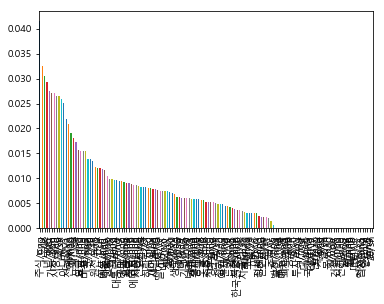

In [45]:
#변수 중요도 시각화
pd.Series(decision_model.feature_importances_,index = X_train.columns).sort_values(ascending=False).plot(kind='bar')

In [46]:
importances_list_all = list(zip(X_train.columns,decision_model.feature_importances_))

In [47]:
importances_list =[]
for element in sorted(importances_list_all,key=lambda x:x[1], reverse=True):    
    if element[1]==0:
        break
    importances_list.append(element[0])
print(importances_list)

['주식/nng', '도/jx', 'ㄴ/jx', '년/nnb', '!!/sf', '가능/nng', '3/sn', '시장/nng', '되/vv', '4/sn', '아니/vcn', '많/va', '전력/nng', '왜/mag', '까지/jx', '../se', '상승/nng', '요금/nng', '주가/nng', '미국/nnp', '돈/nng', '2/sn', '.../se', '원전/nng', '는/jx', '1/sn', '이상/nng', '때문/nnb', '한국/nnp', '위하/vv', '수익/nng', '그/mm', '대통령/nng', '주/vv', '공매/nng', '연금/nng', '수/nnb', '사람/nng', '중국/nnp', '에너지/nng', '지금/nng', '산업/nng', '오르/vv', '알/vv', '?/sf', '하락/nng', '만/jx', '개미/nng', '사업/nng', '좋/va', '떨어지/vv', '이/mm', '나오/vv', '탈/xpn', '잘/mag', '내/vv', '생각/nng', '다/mag', '%/sw', '때/nng', '기업/nng', '오/vv', '나라/nng', '기관/nng', '경제/nng', '문제/nng', '하/vv', '오늘/nng', '은/jx', '중/nnb', '주주/nng', '정부/nng', '만들/vv', '보/vv', '5/sn', '정권/nng', '이익/nng', '문재/nng', '나/vv', '일/nng', '것/nnb', '북한/nnp', '한국전력/nnp', '사/vv', '올리/vv', '지금/mag', '원/nnb', '없/va', '이/vcp', '그렇/va', '가/vv', '정책/nng', '한전/nnp', '모르/vv', '쓰/vv', '있/vv', 'ㅋ/ic', '주/nng']


In [48]:
tag_list = [tag[0] for tag in one_code_list[:int(len(one_code_list)*0.3)]]

In [49]:
tag_list

['20/sn',
 '대하/vv',
 '국가/nng',
 '살/vv',
 '좋/va',
 '이익/nng',
 'ㅋ/nng',
 '투자/nng',
 '중/nnb',
 '그/mm',
 '등/nnb',
 '원/nnb',
 '정책/nng',
 '없/va',
 '요금/nng',
 '크/va',
 'ㅋ/ic',
 '년/nnb',
 '일/nng',
 '시장/nng',
 '발전/nng',
 '안/mag',
 '8/sn',
 '기/nng',
 '전/nng',
 '중국/nnp',
 '나오/vv',
 'ㅎ/nng',
 '한/mm',
 '만/jx',
 '5/sn',
 '전력/nng',
 '경제/nng',
 'ㄴ/jx',
 '많/va',
 '탈/xpn',
 '사업/nng',
 '원전/nng',
 '6/sn',
 '까지/jx',
 '오/vv']

In [50]:
a = set(importances_list)
b = set(tag_list)
intersection_list=list(a.intersection(b))

# RandomForest 0.2

In [51]:
%%time
model_result = Counter()
train_result= Counter()
test_result = Counter()
confusion_matrix_result = Counter()
auc_result = Counter()
one_code_list = all_dict[stock_code]
tag_list = [tag[0] for tag in one_code_list[:]]
y = np.array([labeling(label) for label in earning_data])
classifiers = []
random_state=[4000]
delete_index=[]
for idx, y_element in enumerate(y):    
    if y_element == 0:
        delete_index.append(idx)
x= data_filter_freq[tag_list]
y=np.delete(y,delete_index)
x.drop(index=x.index[delete_index],inplace=True)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
lenx=X_train.shape

nfolds=5
criterion = ["gini", 'entropy']
#grid_search = GridSearchCV(SVC(), param_grid_svc, cv=nfolds)
n_estimators = [3,5,10,100,500,1000,2000]
scoring = 'accuracy'
rf_param_grid = {"max_depth": [3,5,10,15,20,50],
              "max_features": [5,10,30,50,100],
              "n_estimators" :n_estimators,
              "criterion": criterion,
                "random_state":random_state}
# rf_param_grid = {"max_depth": [3],
#               "max_features": [3],
#               "n_estimators" :[10],
#               "criterion": ['entropy'],
#                 'random_state':[4000]}


#gsExtC = GridSearchCV(ExtraTreesClassifier, param_grid = ex_param_grid, cv=nfold, scoring="auc")

print('X_train_shape:',X_train.shape)

classifiers.append(GridSearchCV(RandomForestClassifier(),param_grid = rf_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1))


for single_models in classifiers:    
    single_models.fit(X_train,y_train)
    
    model_str = str(single_models).split('(')[0]
    print(model_str,':',single_models.best_params_)
    pre = single_models.predict(X_test)
    
    
    print(single_models.score(X_test,y_test))
    print(single_models.score(X_train,y_train))    
    print(metrics.accuracy_score(y_test, pre))    

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


X_train_shape: (377, 139)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'n_estimators': 500, 'random_state': 4000}
0.45263157894736844
1.0
0.45263157894736844
Wall time: 12min 12s


In [ ]:
importances_list =[]
for element in sorted(importances_list_all,key=lambda x:x[1], reverse=True):    
    if element[1]==0:
        break
    importances_list.append(element[0])
print(importances_list)

## Xgboost의 장점
1. 규제가 가능하다.  
2. 병렬처리 가능 - 트리 구조를 생각하면 된다.  
3. Built-in Cross-Validation
4. max_depths 까지 간 후에 backword로 Tree Pruning:
5. Continue on Existing Model
6. XGBoost allow users to define custom optimization objectives and evaluation criteria.  

- 참고 사이트  
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [52]:
model_result = Counter()
train_result= Counter()
test_result = Counter()
confusion_matrix_result = Counter()
auc_result = Counter()
one_code_list = all_dict[stock_code]
tag_list = [tag[0] for tag in one_code_list[:int(len(one_code_list)*0.2)]]
y = np.where(earning_data>=0,1,0)
x= data_filter_freq[tag_list]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
lenx=X_train.shape
# if lenx[0]<=10 or lenx[1]<=2:
#     continue
classifiers = []
classifiers_not = []
random_state = [4000]



# gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1]
kernel = ['linear', 'rbf', 'sigmoid']#'precomputed','poly'
nfolds=5
criterion = ["gini", 'entropy']
#grid_search = GridSearchCV(SVC(), param_grid_svc, cv=nfolds)
n_estimators = [500,1000,2000]
learning_rate = [0.01]
max_depth = [3, 5, 10, 15 ,20]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
scoring = 'accuracy'
n_jobs= -1
penalty= ['l2']

linearscv_param_grid = {'C':Cs, 'penalty':penalty, 'random_state':random_state }

svc_param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernel, 'random_state':random_state }

ex_param_grid = {"max_depth": [3, 5, 10,15,20],
              "max_features": [7,8,9,10,11,12],
              "bootstrap": [False,True],
              "n_estimators" :n_estimators,
              "criterion": criterion, 'random_state':random_state }


gb_param_grid = {'loss' : ["deviance",'exponential'],
              'n_estimators' : n_estimators,
              'learning_rate': learning_rate,
              'max_depth': max_depth,
              'min_samples_leaf': [200,400,600],
              'max_features': [0.3, 0.1], 'random_state':random_state  
              }

rf_param_grid = {"max_depth": [3,4,5,10,15,20],
              "max_features": [7,8,9,10,11,12],
              "n_estimators" :n_estimators,
              "criterion": criterion, 'random_state':random_state }

logistic_param_grid = {
    'C': Cs                                   
              }

lda_param_grid = {'solver' : ["svd",'lsqr','eigen'],
              'shrinkage ' : ['auto'], 'random_state':random_state 
              }

kneighbor_param_grid = {'n_neighbors':list(range(1,31))}

xgboost_param_grid ={
    'gamma':[i/10.0 for i in range(0,5)],
     'subsample':[i/100.0 for i in range(75,90,5)],
     'colsample_bytree':[i/100.0 for i in range(75,90,5)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'n_estimators':[100,500,1000,2000], 'random_state':random_state 
}

naive_bayes_param_grid = {
    'priors':None, 'random_state':random_state 
}

mlp_param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05,0.1,1,10,100],
    'learning_rate': ['constant','adaptive'],
    'max_iter':[1000,2000,5000,10000], 'random_state':random_state 
}


#gsExtC = GridSearchCV(ExtraTreesClassifier, param_grid = ex_param_grid, cv=nfold, scoring="auc")

print('X_train_shape:',X_train.shape)
classifiers.append(GridSearchCV(SVC(), svc_param_grid, cv=nfolds,n_jobs=-1))
classifiers.append(GridSearchCV(RandomForestClassifier(),param_grid = rf_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1))
classifiers.append(GridSearchCV(ExtraTreesClassifier(), param_grid = ex_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1))
classifiers.append(GridSearchCV(GradientBoostingClassifier(),param_grid = gb_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1))

classifiers.append(GridSearchCV(KNeighborsClassifier(),param_grid=kneighbor_param_grid,cv=nfolds, scoring=scoring, n_jobs=-1))
classifiers.append(GridSearchCV(LogisticRegression(penalty='l2'),param_grid = logistic_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1))

classifiers.append(GridSearchCV(XGBClassifier(silent=True, learning_rate=0.01, objective='binary:logistic'),param_grid=xgboost_param_grid,cv=nfolds,scoring=scoring,n_jobs=-1))
classifiers.append(GridSearchCV(LinearSVC(),param_grid=linearscv_param_grid, scoring=scoring, cv=nfolds,n_jobs=-1))
classifiers.append(GridSearchCV(MLPClassifier(),param_grid=mlp_param_grid,cv=nfolds,n_jobs=-1)) # 제외



classifiers_not.append(LinearDiscriminantAnalysis())# 튜닝 불가능
classifiers_not.append(GaussianNB())
classifiers_not.append(MultinomialNB())
classifiers_not.append(BernoulliNB())



#classifiers.append(XGBClassifier())
test_accuracy_list = []
train_accuracy_list= [] 
model_accuracy_list= []
confusion_matrix_list = []
auc_list = []
for models in classifiers:
    #print(models)
    models.fit(X_train,y_train)
    
    model_str = str(models).split('(')[0]
    print(model_str,':',models.best_params_)
    pre = models.predict(X_test)
    
    tmp_dict1 = {}
    tmp_dict1[model_str] = models.score(X_test,y_test)
    test_accuracy_list.append(tmp_dict1)
    
    tmp_dict2 = {}
    tmp_dict2[model_str] = models.score(X_train,y_train)
    train_accuracy_list.append(tmp_dict2)
    
    tmp_dict3 = {}
    tmp_dict3[model_str] = metrics.accuracy_score(y_test, pre)
    model_accuracy_list.append(tmp_dict3)
    
    # 전역변수로, 지역변수 문제라 생각한다.
    tmp_dict4 = {}
    tmp_dict4[model_str] = confusion_matrix(y_test,pre)
    confusion_matrix_list.append(tmp_dict4)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pre)
    tmp_dict5 = {}
    tmp_dict5[model_str] = metrics.auc(fpr, tpr)
    auc_list.append(tmp_dict5)
    #confusion_matrix_list.append(confusion_matrix(y_test,pre))
for models in classifiers_not:
    
    models.fit(X_train,y_train)
    
    model_str = str(models).split('(')[0]
    pre = models.predict(X_test)
    
    tmp_dict1 = {}
    tmp_dict1[model_str] = models.score(X_test,y_test)
    test_accuracy_list.append(tmp_dict1)
    
    tmp_dict2 = {}
    tmp_dict2[model_str] = models.score(X_train,y_train)
    train_accuracy_list.append(tmp_dict2)
    
    tmp_dict3 = {}
    tmp_dict3[model_str] = metrics.accuracy_score(y_test, pre)
    model_accuracy_list.append(tmp_dict3)
    
    # 전역변수로, 지역변수 문제라 생각한다.
    tmp_dict4 = {}
    tmp_dict4[model_str] = confusion_matrix(y_test,pre)
    confusion_matrix_list.append(tmp_dict4)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pre)
    tmp_dict5 = {}
    tmp_dict5[model_str] = metrics.auc(fpr, tpr)
    auc_list.append(tmp_dict5)
    #confusion_matrix_list.append(confusion_matrix(y_test,pre))    

    
train_result[stock_code] = train_accuracy_list
test_result[stock_code] = test_accuracy_list
model_result[stock_code] = model_accuracy_list
confusion_matrix_result[stock_code] = confusion_matrix_list
auc_result[stock_code] = auc_list


X_train_shape: (432, 27)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf', 'random_state': 4000}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'criterion': 'entropy', 'max_depth': 4, 'max_features': 9, 'n_estimators': 500, 'random_state': 4000}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 10, 'n_estimators': 500, 'random_state': 4000}
GridSearchCV : {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 3, 'max_features': 0.3, 'min_samples_leaf': 200, 'n_estimators': 500, 'random_state': 4000}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV : {'n_neighbors': 21}
GridSearchCV : {'C': 10}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'colsample_bytree': 0.75, 'gamma': 0.4, 'n_estimators': 2000, 'random_state': 4000, 'reg_alpha': 1e-05, 'subsample': 0.75}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV : {'C': 10, 'penalty': 'l2', 'random_state': 4000}
GridSearchCV : {'activation': 'tanh', 'alpha': 100, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 1000, 'random_state': 4000, 'solver': 'sgd'}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}
GridSearchCV : {'criterion': 'gini', 'max_depth': 5, 'max_features': 12, 'n_estimators': 500}
GridSearchCV : {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 11, 'n_estimators': 500}
GridSearchCV : {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 3, 'max_features': 0.3, 'min_samples_leaf': 200, 'n_estimators': 500}
GridSearchCV : {'n_neighbors': 19}
GridSearchCV : {'C': 0.01}
GridSearchCV : {'colsample_bytree': 0.8, 'gamma': 0.4, 'n_estimators': 1000, 'reg_alpha': 1e-05, 'subsample': 0.75}
GridSearchCV : {'C': 0.001, 'penalty': 'l2'}
GridSearchCV : {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'max_iter': 10000, 'solver': 'adam'}

In [53]:
# model_result = Counter()
# train_result= Counter()
# test_result = Counter()
# confusion_matrix_result = Counter()
# auc_result = Counter()
# one_code_list = all_dict[stock_code]
# tag_list = [tag[0] for tag in one_code_list[:int(len(one_code_list)*0.2)]]
# y = np.where(earning_data>=0,1,0)
# x= data_filter_freq[tag_list]
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=False)
# lenx=X_train.shape
# # if lenx[0]<=10 or lenx[1]<=2 :
# #     continue
# random_state = 2
# classifiers = []
# # rf_param_grid = {"max_depth": [10,15,20],
# #               "max_features": [7,8,9,10,11,12],
# #               "n_estimators" :[2000],
# #               "criterion": ["gini",'entropy']}


# # gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# classifiers.append(SVC(random_state=random_state,C=0.0001))
# classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
# classifiers.append(RandomForestClassifier(random_state=random_state,n_estimators=1000,max_depth=3))
# classifiers.append(ExtraTreesClassifier(random_state=random_state))
# classifiers.append(GradientBoostingClassifier(random_state=random_state,learning_rate=0.01))
# classifiers.append(MLPClassifier(random_state=random_state,max_iter=2000)) # 제외
# classifiers.append(KNeighborsClassifier())
# classifiers.append(LogisticRegression(random_state = random_state,C=0.001))
# classifiers.append(LinearDiscriminantAnalysis())# 여기까지
# classifiers.append(GaussianNB())
# classifiers.append(MultinomialNB())
# classifiers.append(BernoulliNB())
# classifiers.append(XGBClassifier(silent=True, learning_rate=0.01, subsample=0.8, objective='binary:logistic',n_estimators=1000,reg_alpha=0.3))
# classifiers.append(LinearSVC(random_state=100,C=0.01))
# #classifiers.append(XGBClassifier())
# test_accuracy_list = []
# train_accuracy_list= [] 
# model_accuracy_list= []
# confusion_matrix_list = []
# auc_list = []
# for models in classifiers:
#     #print(models)
#     models.fit(X_train,y_train)
#     model_str = str(models).split('(')[0]
#     pre = models.predict(X_test)
    
#     tmp_dict1 = {}
#     tmp_dict1[model_str] = models.score(X_test,y_test)
#     test_accuracy_list.append(tmp_dict1)
    
#     tmp_dict2 = {}
#     tmp_dict2[model_str] = models.score(X_train,y_train)
#     train_accuracy_list.append(tmp_dict2)
    
#     tmp_dict3 = {}
#     tmp_dict3[model_str] = metrics.accuracy_score(y_test, pre)
#     model_accuracy_list.append(tmp_dict3)
    
#     # 전역변수로, 지역변수 문제라 생각한다.
#     tmp_dict4 = {}
#     tmp_dict4[model_str] = confusion_matrix(y_test,pre)
#     confusion_matrix_list.append(tmp_dict4)
    
#     fpr, tpr, thresholds = metrics.roc_curve(y_test, pre)
#     tmp_dict5 = {}
#     tmp_dict5[model_str] = metrics.auc(fpr, tpr)
#     auc_list.append(tmp_dict5)
#     #confusion_matrix_list.append(confusion_matrix(y_test,pre))
    
# train_result[stock_code] = train_accuracy_list
# test_result[stock_code] = test_accuracy_list
# model_result[stock_code] = model_accuracy_list
# confusion_matrix_result[stock_code] = confusion_matrix_list
# auc_result[stock_code] = auc_list


In [54]:
# for model in classifiers:
#     print(model)
#     #model_str = str(model)
#     #print(type(model_str))
#     #print(model_str.split('(')[0])

In [55]:
ratio_y = y.sum()/len(y)
print(ratio_y,1-ratio_y)

0.5341959334565619 0.4658040665434381


In [56]:
ratio_y_test = y_test.sum()/len(y_test)
print(ratio_y_test,1-ratio_y_test)

0.6788990825688074 0.3211009174311926


In [57]:
# models = LinearDiscriminantAnalysis(solver='eigen')
# models.fit(X_train,y_train)
# model_str = str(models).split('(')[0]
# pre = models.predict(X_test)
# models.score(X_test,y_test)

In [58]:
# models = LinearDiscriminantAnalysis(solver='lsqr')
# models.fit(X_train,y_train)
# model_str = str(models).split('(')[0]
# pre = models.predict(X_test)
# models.score(X_test,y_test)

In [59]:
model_list=['svc',
'randomforestclassifier',
'extratreesclassifier',
'gradientboostingclassifier',
'kneighborsclassfier',
'logisticregression',
'xgbclassifier',
'linearsvc',
'mlpclassifier']

In [60]:
for idx,element in enumerate(model_list):    
    tmp_dict = {}
    tmp_dict[element] = confusion_matrix_result[stock_code][idx]['GridSearchCV']
    confusion_matrix_result[stock_code][idx] = tmp_dict

In [61]:
confusion_matrix_result

Counter({'015760': [{'svc': array([[ 3, 32],
                  [13, 61]], dtype=int64)},
          {'randomforestclassifier': array([[15, 20],
                  [34, 40]], dtype=int64)},
          {'extratreesclassifier': array([[11, 24],
                  [26, 48]], dtype=int64)},
          {'gradientboostingclassifier': array([[ 6, 29],
                  [23, 51]], dtype=int64)},
          {'kneighborsclassfier': array([[21, 14],
                  [42, 32]], dtype=int64)},
          {'logisticregression': array([[17, 18],
                  [29, 45]], dtype=int64)},
          {'xgbclassifier': array([[20, 15],
                  [39, 35]], dtype=int64)},
          {'linearsvc': array([[31,  4],
                  [64, 10]], dtype=int64)},
          {'mlpclassifier': array([[ 0, 35],
                  [ 0, 74]], dtype=int64)},
          {'LinearDiscriminantAnalysis': array([[18, 17],
                  [29, 45]], dtype=int64)},
          {'GaussianNB': array([[17, 18],
                  [

In [62]:
for idx,element in enumerate(model_list):    
    tmp_dict = {}
    tmp_dict[element] = model_result[stock_code][idx]['GridSearchCV']
    model_result[stock_code][idx] = tmp_dict
print(model_result)
for idx,element in enumerate(model_list):    
    tmp_dict = {}
    tmp_dict[element] = train_result[stock_code][idx]['GridSearchCV']
    train_result[stock_code][idx] = tmp_dict
print(train_result)
for idx,element in enumerate(model_list):    
    tmp_dict = {}
    tmp_dict[element] = test_result[stock_code][idx]['GridSearchCV']
    test_result[stock_code][idx] = tmp_dict
print(test_result)

Counter({'015760': [{'svc': 0.5871559633027523}, {'randomforestclassifier': 0.5045871559633027}, {'extratreesclassifier': 0.5412844036697247}, {'gradientboostingclassifier': 0.5229357798165137}, {'kneighborsclassfier': 0.48623853211009177}, {'logisticregression': 0.5688073394495413}, {'xgbclassifier': 0.5045871559633027}, {'linearsvc': 0.3761467889908257}, {'mlpclassifier': 0.6788990825688074}, {'LinearDiscriminantAnalysis': 0.5779816513761468}, {'GaussianNB': 0.4954128440366973}, {'MultinomialNB': 0.5045871559633027}, {'BernoulliNB': 0.6238532110091743}]})
Counter({'015760': [{'svc': 0.5810185185185185}, {'randomforestclassifier': 0.7939814814814815}, {'extratreesclassifier': 0.6643518518518519}, {'gradientboostingclassifier': 0.6018518518518519}, {'kneighborsclassfier': 0.5949074074074074}, {'logisticregression': 0.5949074074074074}, {'xgbclassifier': 0.9861111111111112}, {'linearsvc': 0.5046296296296297}, {'mlpclassifier': 0.5370370370370371}, {'LinearDiscriminantAnalysis': 0.599537

In [63]:
# for idx,element in enumerate(model_list):    
#     tmp_dict = {}
#     tmp_dict[element] = model_result[stock_code][idx]['GridSearchCV']
#     model_result[stock_code][idx] = tmp_dict


In [64]:
# model_result

In [65]:
# for idx,element in enumerate(model_list):    
#     tmp_dict = {}
#     tmp_dict[element] = train_result[stock_code][idx]['GridSearchCV']
#     train_result[stock_code][idx] = tmp_dict

In [66]:
# train_result 

In [67]:
# for idx,element in enumerate(model_list):    
#     tmp_dict = {}
#     tmp_dict[element] = test_result[stock_code][idx]['GridSearchCV']
#     test_result[stock_code][idx] = tmp_dict

In [68]:
# test_result

In [69]:
# for idx,element in enumerate(model_list):    
#     tmp_dict = {}
#     tmp_dict[element] = auc_result[stock_code][idx]['GridSearchCV']
#     auc_result[stock_code][idx] = tmp_dict

In [70]:
# auc_list

In [71]:
# for i in range(len(earning_data)-2):
#     eidx = earning_data.index
#     # 수익률 이전 행 날짜가 전날 날짜가 아니라 그이상 차이가 날때
#     if (eidx[i+1] - eidx[i]).days > 1:
#         # 휴일 or 주말이 끼면 그 날을 포함해서 다음 날에 반영한다.
#         try:
#             #data_filter_freq가 earning_data 보다 날짜가 하나 적다.
#             print(data_filter_freq[eidx[i]+relativedelta(days=1):eidx[i+1]].sum()) # [i]는 [i+1]보다 1이상 차이난다.
#             # 근데 data_filter_freq 데이터에서 earning_data의 인덱스가 없는 경우가 있다.
#             data_filter_freq.loc[eidx[i+1],:] = data_filter_freq[eidx[i]+relativedelta(days=1):eidx[i+1]].sum()
#             #del(data_filter_freq[eidx[i]+relativedelta(days=1):eidx[i+1]-relativedelta(days=1)])

#             #data_filter_freq.drop(pd.date_range(eidx[i]+relativedelta(days=1),eidx[i+1]-relativedelta(days=1)),axis=0,inplace=True)
#         except:
#             print(i)
#         #KeyError 발생
#         #해결방법
#         #1.존재 여부를 일일이 살펴 제어문을 걸어준다.
#         #2. 
        

In [72]:
#{'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 8, 'n_estimators': 500, 'random_state': 4000}


모든 학습 모델들이 overfitting하여 이에 대한 해결책이 필요하다.
1. 학습 데이터 비율증가.
2. 파라미터 튜닝  - 가장 성능이 좋은 extraclassifier에 대해서 해준다.


- n_estimators  값 증가
- max_feature 줄이기
- max_depths 줄이기

In [73]:
XGBClassifier(silent=True, learning_rate=0.01)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [74]:
# model_result = Counter()
# train_result= Counter()
# test_result = Counter()
# confusion_matrix_result = Counter()
# auc_result = Counter()
# one_code_list = all_dict[stock_code]
# tag_list = [tag[0] for tag in one_code_list[:int(len(one_code_list)*0.2)]]
# y = np.where(earning_data>=0,1,0)
# x= data_filter_freq[tag_list]
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=False)
# lenx=X_train.shape
# ex_param_grid = {"max_depth": [3, 5, 10,15,20],
#               "max_features": [7,8,9,10,11,12],
#               "bootstrap": [False,True],
#               "n_estimators" :[3,5,10,100,500,1000],
#               "criterion": ['gini','entropy'], 'random_state':random_state }
# #model = ExtraTreesClassifier(bootstrap=False,criterion='gini',max_depth=5, max_features=4,n_estimators=20000, random_state=4000,n_jobs=-1)
# model = GridSearchCV(ExtraTreesClassifier(), param_grid = ex_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1)
# model.fit(X_train,y_train)
# pre = model.predict(X_test)

In [75]:
# model.score(X_train,y_train)

In [76]:
# metrics.accuracy_score(y_test,pre)

In [77]:
# confusion_matrix(y_test,pre)

In [78]:
# model.best_estimator_

## random forest vs extra 
1) When choosing variables at a split, samples are drawn from the entire training set instead of a bootstrap sample of the training set.

2) Splits are chosen completely at random from the range of values in the sample at each split.

The result from these two things are many more "leaves".

In [79]:
def labeling(data):
    if data>0:
        data = 1
    elif data <0:
        data = -1
    return data
            
        

In [80]:
# model_result = Counter()
# train_result= Counter()
# test_result = Counter()
# confusion_matrix_result = Counter()
# auc_result = Counter()
# one_code_list = all_dict[stock_code]
# tag_list = [tag[0] for tag in one_code_list[:int(len(one_code_list)*0.2)]]
# y = np.where(earning_data>0,1,0)
# x= data_filter_freq[tag_list]
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=False)
# lenx=X_train.shape
# ex_param_grid = {"max_depth": [3, 5, 10,15,20],
#               "max_features": [7,8,9,10,11,12],
#               "bootstrap": [False,True],
#               "n_estimators" :[3,5,10,100,500,1000],
#               "criterion": ['gini','entropy'], 'random_state':random_state}
# #model = ExtraTreesClassifier(bootstrap=False,criterion='gini',max_depth=5, max_features=4,n_estimators=20000, random_state=4000,n_jobs=-1)
# model = GridSearchCV(ExtraTreesClassifier(), param_grid = ex_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1)
# model.fit(X_train,y_train)
# pre = model.predict(X_test)

In [81]:
#model.best_estimator_

In [82]:
#model.best_score_

In [83]:
#metrics.accuracy_score(pre,y_test)

In [84]:
#y

In [85]:
# delete_index=[]
# for idx, y_element in enumerate(y):    
#     if y_element == 0:
#         delete_index.append(idx)
# print(delete_index)

# 수익률이 0인것 제거

In [86]:
%%time


model_result = Counter()
train_result= Counter()
test_result = Counter()
confusion_matrix_result = Counter()
auc_result = Counter()
one_code_list = all_dict[stock_code]
tag_list = [tag[0] for tag in one_code_list[:int(len(one_code_list)*0.2)]]
y = np.array([labeling(label) for label in earning_data])


delete_index=[]
for idx, y_element in enumerate(y):    
    if y_element == 0:
        delete_index.append(idx)
x= data_filter_freq[tag_list]
y=np.delete(y,delete_index)
x.drop(index=x.index[delete_index],inplace=True)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=False)
lenx=X_train.shape
# if lenx[0]<=10 or lenx[1]<=2:
#     continue
classifiers = []
classifiers_not = []
random_state = [4000]



# gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1]
kernel = ['linear', 'rbf', 'sigmoid']#'precomputed','poly'
nfolds=5
criterion = ["gini", 'entropy']
#grid_search = GridSearchCV(SVC(), param_grid_svc, cv=nfolds)
n_estimators = [500,1000,2000]
learning_rate = [0.01]
max_depth = [3, 5, 10, 15 ,20]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
scoring = 'accuracy'
n_jobs= -1
penalty= ['l2']

linearscv_param_grid = {'C':Cs, 'penalty':penalty, 'random_state':random_state }

svc_param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernel, 'random_state':random_state }

ex_param_grid = {"max_depth": [3, 5, 10,15,20],
              "max_features": [7,8,9,10,11,12],
              "bootstrap": [False,True],
              "n_estimators" :n_estimators,
              "criterion": criterion, 'random_state':random_state }


gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : n_estimators,
              'learning_rate': learning_rate,
              'max_depth': max_depth,
              'min_samples_leaf': [200,400,600],
              'max_features': [0.3, 0.1], 'random_state':random_state  
              }

rf_param_grid = {"max_depth": [3,4,5,10,15,20],
              "max_features": [7,8,9,10,11,12],
              "n_estimators" :n_estimators,
              "criterion": criterion, 'random_state':random_state }

logistic_param_grid = {
    'C': Cs                                   
              }

lda_param_grid = {'solver' : ["svd",'lsqr','eigen'],
              'shrinkage ' : ['auto'], 'random_state':random_state 
              }

kneighbor_param_grid = {'n_neighbors':list(range(1,31))}

xgboost_param_grid ={
    'gamma':[i/10.0 for i in range(0,5)],
     'subsample':[i/100.0 for i in range(75,90,5)],
     'colsample_bytree':[i/100.0 for i in range(75,90,5)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'n_estimators':[100,500,1000,2000], 'random_state':random_state 
}

naive_bayes_param_grid = {
    'priors':None, 'random_state':random_state 
}

mlp_param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05,0.1,1,10,100],
    'learning_rate': ['constant','adaptive'],
    'max_iter':[1000,2000,5000,10000], 'random_state':random_state 
}


#gsExtC = GridSearchCV(ExtraTreesClassifier, param_grid = ex_param_grid, cv=nfold, scoring="auc")

print('X_train_shape:',X_train.shape)
classifiers.append(GridSearchCV(SVC(), svc_param_grid, cv=nfolds,n_jobs=-1))
classifiers.append(GridSearchCV(RandomForestClassifier(),param_grid = rf_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1))
classifiers.append(GridSearchCV(ExtraTreesClassifier(), param_grid = ex_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1))
classifiers.append(GridSearchCV(GradientBoostingClassifier(),param_grid = gb_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1))

classifiers.append(GridSearchCV(KNeighborsClassifier(),param_grid=kneighbor_param_grid,cv=nfolds, scoring=scoring, n_jobs=-1))
classifiers.append(GridSearchCV(LogisticRegression(penalty='l2'),param_grid = logistic_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1))

classifiers.append(GridSearchCV(XGBClassifier(silent=True, learning_rate=0.01, objective='binary:logistic'),param_grid=xgboost_param_grid,cv=nfolds,scoring=scoring,n_jobs=-1))
classifiers.append(GridSearchCV(LinearSVC(),param_grid=linearscv_param_grid, scoring=scoring, cv=nfolds,n_jobs=-1))
classifiers.append(GridSearchCV(MLPClassifier(),param_grid=mlp_param_grid,cv=nfolds,n_jobs=-1)) # 제외



classifiers_not.append(LinearDiscriminantAnalysis())# 튜닝 불가능
classifiers_not.append(GaussianNB())
classifiers_not.append(MultinomialNB())
classifiers_not.append(BernoulliNB())



#classifiers.append(XGBClassifier())
test_accuracy_list = []
train_accuracy_list= [] 
model_accuracy_list= []
confusion_matrix_list = []
auc_list = []
for models in classifiers:
    #print(models)
    models.fit(X_train,y_train)
    
    model_str = str(models).split('(')[0]
    print(model_str,':',models.best_params_)
    pre = models.predict(X_test)
    
    tmp_dict1 = {}
    tmp_dict1[model_str] = models.score(X_test,y_test)
    test_accuracy_list.append(tmp_dict1)
    
    tmp_dict2 = {}
    tmp_dict2[model_str] = models.score(X_train,y_train)
    train_accuracy_list.append(tmp_dict2)
    
    tmp_dict3 = {}
    tmp_dict3[model_str] = metrics.accuracy_score(y_test, pre)
    model_accuracy_list.append(tmp_dict3)
    
    # 전역변수로, 지역변수 문제라 생각한다.
    tmp_dict4 = {}
    tmp_dict4[model_str] = confusion_matrix(y_test,pre)
    confusion_matrix_list.append(tmp_dict4)    
    
    #confusion_matrix_list.append(confusion_matrix(y_test,pre))
for models in classifiers_not:
    
    models.fit(X_train,y_train)
    
    model_str = str(models).split('(')[0]
    pre = models.predict(X_test)
    
    tmp_dict1 = {}
    tmp_dict1[model_str] = models.score(X_test,y_test)
    test_accuracy_list.append(tmp_dict1)
    
    tmp_dict2 = {}
    tmp_dict2[model_str] = models.score(X_train,y_train)
    train_accuracy_list.append(tmp_dict2)
    
    tmp_dict3 = {}
    tmp_dict3[model_str] = metrics.accuracy_score(y_test, pre)
    model_accuracy_list.append(tmp_dict3)
    
    # 전역변수로, 지역변수 문제라 생각한다.
    tmp_dict4 = {}
    tmp_dict4[model_str] = confusion_matrix(y_test,pre)
    confusion_matrix_list.append(tmp_dict4)
  
    #confusion_matrix_list.append(confusion_matrix(y_test,pre))    

    
train_result[stock_code] = train_accuracy_list
test_result[stock_code] = test_accuracy_list
model_result[stock_code] = model_accuracy_list
confusion_matrix_result[stock_code] = confusion_matrix_list



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


X_train_shape: (316, 27)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'C': 10, 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 4000}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'n_estimators': 500, 'random_state': 4000}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 7, 'n_estimators': 1000, 'random_state': 4000}
GridSearchCV : {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 3, 'max_features': 0.3, 'min_samples_leaf': 200, 'n_estimators': 500, 'random_state': 4000}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV : {'n_neighbors': 26}
GridSearchCV : {'C': 0.0001}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'colsample_bytree': 0.75, 'gamma': 0.0, 'n_estimators': 100, 'random_state': 4000, 'reg_alpha': 100, 'subsample': 0.75}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV : {'C': 100, 'penalty': 'l2', 'random_state': 4000}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 1000, 'random_state': 4000, 'solver': 'adam'}
Wall time: 26min 6s


In [87]:
for idx,element in enumerate(model_list):    
    tmp_dict = {}
    tmp_dict[element] = model_result[stock_code][idx]['GridSearchCV']
    model_result[stock_code][idx] = tmp_dict
print('model_result')
print(model_result)
for idx,element in enumerate(model_list):    
    tmp_dict = {}
    tmp_dict[element] = train_result[stock_code][idx]['GridSearchCV']
    train_result[stock_code][idx] = tmp_dict
print('train_result')
print(train_result)
for idx,element in enumerate(model_list):    
    tmp_dict = {}
    tmp_dict[element] = test_result[stock_code][idx]['GridSearchCV']
    test_result[stock_code][idx] = tmp_dict
print('test_result')
print(test_result)

model_result
Counter({'015760': [{'svc': 0.4551282051282051}, {'randomforestclassifier': 0.5064102564102564}, {'extratreesclassifier': 0.4807692307692308}, {'gradientboostingclassifier': 0.4551282051282051}, {'kneighborsclassfier': 0.4807692307692308}, {'logisticregression': 0.44871794871794873}, {'xgbclassifier': 0.4551282051282051}, {'linearsvc': 0.5256410256410257}, {'mlpclassifier': 0.44871794871794873}, {'LinearDiscriminantAnalysis': 0.5192307692307693}, {'GaussianNB': 0.5448717948717948}, {'MultinomialNB': 0.5512820512820513}, {'BernoulliNB': 0.532051282051282}]})
train_result
Counter({'015760': [{'svc': 1.0}, {'randomforestclassifier': 1.0}, {'extratreesclassifier': 0.7563291139240507}, {'gradientboostingclassifier': 0.5727848101265823}, {'kneighborsclassfier': 0.6170886075949367}, {'logisticregression': 0.5664556962025317}, {'xgbclassifier': 0.5727848101265823}, {'linearsvc': 0.5316455696202531}, {'mlpclassifier': 1.0}, {'LinearDiscriminantAnalysis': 0.6455696202531646}, {'Gaus



model_result
Counter({'015760': [{'svc': 0.5263157894736842}, {'randomforestclassifier': 0.6140350877192983}, {'extratreesclassifier': 0.631578947368421}, {'gradientboostingclassifier': 0.5789473684210527}, {'kneighborsclassfier': 0.5789473684210527}, {'logisticregression': 0.5526315789473685}, {'xgbclassifier': 0.5701754385964912}, {'linearsvc': 0.5087719298245614}, {'mlpclassifier': 0.5087719298245614}, {'LinearDiscriminantAnalysis': 0.5087719298245614}, {'GaussianNB': 0.5526315789473685}, {'MultinomialNB': 0.5350877192982456}, {'BernoulliNB': 0.5}]})
train_result
Counter({'015760': [{'svc': 0.9956521739130435}, {'randomforestclassifier': 0.7913043478260869}, {'extratreesclassifier': 0.8130434782608695}, {'gradientboostingclassifier': 0.5565217391304348}, {'kneighborsclassfier': 0.6173913043478261}, {'logisticregression': 0.6347826086956522}, {'xgbclassifier': 1.0}, {'linearsvc': 0.6739130434782609}, {'mlpclassifier': 1.0}, {'LinearDiscriminantAnalysis': 0.6608695652173913}, {'GaussianNB': 0.5347826086956522}, {'MultinomialNB': 0.6304347826086957}, {'BernoulliNB': 0.5869565217391305}]})
test_result
Counter({'015760': [{'svc': 0.5263157894736842}, {'randomforestclassifier': 0.6140350877192983}, {'extratreesclassifier': 0.631578947368421}, {'gradientboostingclassifier': 0.5789473684210527}, {'kneighborsclassfier': 0.5789473684210527}, {'logisticregression': 0.5526315789473685}, {'xgbclassifier': 0.5701754385964912}, {'linearsvc': 0.5087719298245614}, {'mlpclassifier': 0.5087719298245614}, {'LinearDiscriminantAnalysis': 0.5087719298245614}, {'GaussianNB': 0.5526315789473685}, {'MultinomialNB': 0.5350877192982456}, {'BernoulliNB': 0.5}]})

## 수익률 0 제거하고 test 비율 0.2

In [88]:
%%time

#초기화
model_result = Counter()
train_result= Counter()
test_result = Counter()
confusion_matrix_result = Counter()
auc_result = Counter()
one_code_list = all_dict[stock_code]
tag_list = [tag[0] for tag in one_code_list[:int(len(one_code_list)*0.2)]]
y = np.array([labeling(label) for label in earning_data])


delete_index=[]
for idx, y_element in enumerate(y):    
    if y_element == 0:
        delete_index.append(idx)
x= data_filter_freq[tag_list]
y=np.delete(y,delete_index)
x.drop(index=x.index[delete_index],inplace=True)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
lenx=X_train.shape
# if lenx[0]<=10 or lenx[1]<=2:
#     continue
classifiers = []
classifiers_not = []
random_state = [4000]



# gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1]
kernel = ['linear', 'rbf', 'sigmoid']#'precomputed','poly'
nfolds=5
criterion = ["gini", 'entropy']
#grid_search = GridSearchCV(SVC(), param_grid_svc, cv=nfolds)
n_estimators = [500,1000,2000]
learning_rate = [0.01]
max_depth = [3, 5, 10, 15 ,20]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
scoring = 'accuracy'
n_jobs= -1
penalty= ['l2']

linearscv_param_grid = {'C':Cs, 'penalty':penalty, 'random_state':random_state }

svc_param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernel, 'random_state':random_state }

ex_param_grid = {"max_depth": [3, 5, 10,15,20],
              "max_features": [7,8,9,10,11,12],
              "bootstrap": [False,True],
              "n_estimators" :n_estimators,
              "criterion": criterion, 'random_state':random_state }


gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : n_estimators,
              'learning_rate': learning_rate,
              'max_depth': max_depth,
              'min_samples_leaf': [200,400,600],
              'max_features': [0.3, 0.1], 'random_state':random_state  
              }

rf_param_grid = {"max_depth": [3,4,5,10,15,20],
              "max_features": [7,8,9,10,11,12],
              "n_estimators" :n_estimators,
              "criterion": criterion, 'random_state':random_state }

logistic_param_grid = {
    'C': Cs                                   
              }

lda_param_grid = {'solver' : ["svd",'lsqr','eigen'],
              'shrinkage ' : ['auto'], 'random_state':random_state 
              }

kneighbor_param_grid = {'n_neighbors':list(range(1,31))}

xgboost_param_grid ={
    'gamma':[i/10.0 for i in range(0,5)],
     'subsample':[i/100.0 for i in range(75,90,5)],
     'colsample_bytree':[i/100.0 for i in range(75,90,5)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'n_estimators':[100,500,1000,2000], 'random_state':random_state 
}

naive_bayes_param_grid = {
    'priors':None, 'random_state':random_state 
}

mlp_param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05,0.1,1,10,100],
    'learning_rate': ['constant','adaptive'],
    'max_iter':[1000,2000,5000,10000], 'random_state':random_state 
}


#gsExtC = GridSearchCV(ExtraTreesClassifier, param_grid = ex_param_grid, cv=nfold, scoring="auc")

print('X_train_shape:',X_train.shape)
classifiers.append(GridSearchCV(SVC(), svc_param_grid, cv=nfolds,n_jobs=-1))
classifiers.append(GridSearchCV(RandomForestClassifier(),param_grid = rf_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1))
classifiers.append(GridSearchCV(ExtraTreesClassifier(), param_grid = ex_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1))
classifiers.append(GridSearchCV(GradientBoostingClassifier(),param_grid = gb_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1))

classifiers.append(GridSearchCV(KNeighborsClassifier(),param_grid=kneighbor_param_grid,cv=nfolds, scoring=scoring, n_jobs=-1))
classifiers.append(GridSearchCV(LogisticRegression(penalty='l2'),param_grid = logistic_param_grid, cv=nfolds, scoring=scoring, n_jobs=-1))

classifiers.append(GridSearchCV(XGBClassifier(silent=True, learning_rate=0.01, objective='binary:logistic'),param_grid=xgboost_param_grid,cv=nfolds,scoring=scoring,n_jobs=-1))
classifiers.append(GridSearchCV(LinearSVC(),param_grid=linearscv_param_grid, scoring=scoring, cv=nfolds,n_jobs=-1))
classifiers.append(GridSearchCV(MLPClassifier(),param_grid=mlp_param_grid,cv=nfolds,n_jobs=-1)) # 제외



classifiers_not.append(LinearDiscriminantAnalysis())# 튜닝 불가능
classifiers_not.append(GaussianNB())
classifiers_not.append(MultinomialNB())
classifiers_not.append(BernoulliNB())



#classifiers.append(XGBClassifier())
test_accuracy_list = []
train_accuracy_list= [] 
model_accuracy_list= []
confusion_matrix_list = []
auc_list = []
for models in classifiers:
    #print(models)
    models.fit(X_train,y_train)
    
    model_str = str(models).split('(')[0]
    print(model_str,':',models.best_params_)
    pre = models.predict(X_test)
    
    tmp_dict1 = {}
    tmp_dict1[model_str] = models.score(X_test,y_test)
    test_accuracy_list.append(tmp_dict1)
    
    tmp_dict2 = {}
    tmp_dict2[model_str] = models.score(X_train,y_train)
    train_accuracy_list.append(tmp_dict2)
    
    tmp_dict3 = {}
    tmp_dict3[model_str] = metrics.accuracy_score(y_test, pre)
    model_accuracy_list.append(tmp_dict3)
    
    # 전역변수로, 지역변수 문제라 생각한다.
    tmp_dict4 = {}
    tmp_dict4[model_str] = confusion_matrix(y_test,pre)
    confusion_matrix_list.append(tmp_dict4)    
    
    #confusion_matrix_list.append(confusion_matrix(y_test,pre))
for models in classifiers_not:
    
    models.fit(X_train,y_train)
    
    model_str = str(models).split('(')[0]
    pre = models.predict(X_test)
    
    tmp_dict1 = {}
    tmp_dict1[model_str] = models.score(X_test,y_test)
    test_accuracy_list.append(tmp_dict1)
    
    tmp_dict2 = {}
    tmp_dict2[model_str] = models.score(X_train,y_train)
    train_accuracy_list.append(tmp_dict2)
    
    tmp_dict3 = {}
    tmp_dict3[model_str] = metrics.accuracy_score(y_test, pre)
    model_accuracy_list.append(tmp_dict3)
    
    # 전역변수로, 지역변수 문제라 생각한다.
    tmp_dict4 = {}
    tmp_dict4[model_str] = confusion_matrix(y_test,pre)
    confusion_matrix_list.append(tmp_dict4)
  
    #confusion_matrix_list.append(confusion_matrix(y_test,pre))    

    
train_result[stock_code] = train_accuracy_list
test_result[stock_code] = test_accuracy_list
model_result[stock_code] = model_accuracy_list
confusion_matrix_result[stock_code] = confusion_matrix_list



X_train_shape: (377, 27)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear', 'random_state': 4000}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'criterion': 'gini', 'max_depth': 5, 'max_features': 11, 'n_estimators': 1000, 'random_state': 4000}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'n_estimators': 500, 'random_state': 4000}
GridSearchCV : {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 3, 'max_features': 0.3, 'min_samples_leaf': 200, 'n_estimators': 500, 'random_state': 4000}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'n_neighbors': 6}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV : {'C': 0.0001}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'colsample_bytree': 0.75, 'gamma': 0.0, 'n_estimators': 100, 'random_state': 4000, 'reg_alpha': 100, 'subsample': 0.75}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV : {'C': 0.1, 'penalty': 'l2', 'random_state': 4000}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV : {'activation': 'relu', 'alpha': 10, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'max_iter': 1000, 'random_state': 4000, 'solver': 'sgd'}
Wall time: 31min 16s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [89]:
for idx,element in enumerate(model_list):    
    tmp_dict = {}
    tmp_dict[element] = model_result[stock_code][idx]['GridSearchCV']
    model_result[stock_code][idx] = tmp_dict
print('model_result')
print(model_result)
for idx,element in enumerate(model_list):    
    tmp_dict = {}
    tmp_dict[element] = train_result[stock_code][idx]['GridSearchCV']
    train_result[stock_code][idx] = tmp_dict
print('train_result')
print(train_result)
for idx,element in enumerate(model_list):    
    tmp_dict = {}
    tmp_dict[element] = test_result[stock_code][idx]['GridSearchCV']
    test_result[stock_code][idx] = tmp_dict
print('test_result')
print(test_result)

model_result
Counter({'015760': [{'svc': 0.37894736842105264}, {'randomforestclassifier': 0.4842105263157895}, {'extratreesclassifier': 0.4105263157894737}, {'gradientboostingclassifier': 0.3684210526315789}, {'kneighborsclassfier': 0.35789473684210527}, {'logisticregression': 0.3684210526315789}, {'xgbclassifier': 0.3684210526315789}, {'linearsvc': 0.5263157894736842}, {'mlpclassifier': 0.5789473684210527}, {'LinearDiscriminantAnalysis': 0.43157894736842106}, {'GaussianNB': 0.5473684210526316}, {'MultinomialNB': 0.43157894736842106}, {'BernoulliNB': 0.6105263157894737}]})
train_result
Counter({'015760': [{'svc': 0.5782493368700266}, {'randomforestclassifier': 0.9018567639257294}, {'extratreesclassifier': 0.6392572944297082}, {'gradientboostingclassifier': 0.5755968169761273}, {'kneighborsclassfier': 0.6578249336870027}, {'logisticregression': 0.5596816976127321}, {'xgbclassifier': 0.5755968169761273}, {'linearsvc': 0.6312997347480106}, {'mlpclassifier': 0.7055702917771883}, {'LinearDi

In [90]:
ratio_y_test = y_test.sum()/len(y_test)
print(ratio_y_test,1-ratio_y_test)

0.2631578947368421 0.736842105263158
